In [1]:
from typing import Dict, List

import os
import torch
import numpy as np
import networkx as nx
from networkx import DiGraph
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_geometric.nn.aggr.fused import FusedAggregation

from master_thesis.classification_models import BaseModel, LDPModel
from master_thesis.classification_models.ltp_model import _extract_single_graph_features, _aggregate_features
from master_thesis.classification_models.utils import LocalDegreeProfile
from master_thesis.tools.data import  load_np_data, Preprocessing
from master_thesis.tools.plots import draw_network

NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeBias/networks"

aggr = FusedAggregation(['min', 'max', 'mean', 'std'])

In [2]:
# Load network files
filenames = [f for f in os.listdir(NETWORKS_DIR_PATH) if f.endswith(".npy")]
print(f"Found {len(filenames)} networks")
X, y = Preprocessing()(*load_np_data(NETWORKS_DIR_PATH))

Found 1000 networks


Data(edge_index=[2, 10], num_nodes=7, y=[1], num_edges=10)

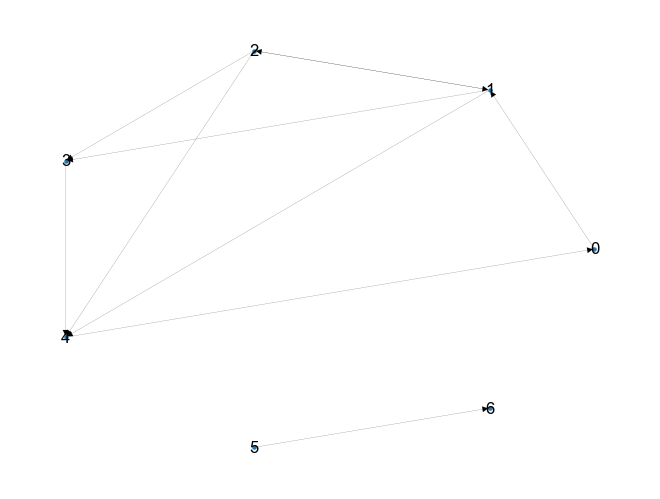

In [3]:
# Create sample directed graph
G = DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 0), (0, 1), (1, 3), (1, 4), (2, 1), (2, 4), (5, 6)])
draw_network(G, with_labels=True)

# Create torch_geometric data from the graph
data = BaseModel.nx2geometric("cpu", G, x_attr=None, label=1)
data

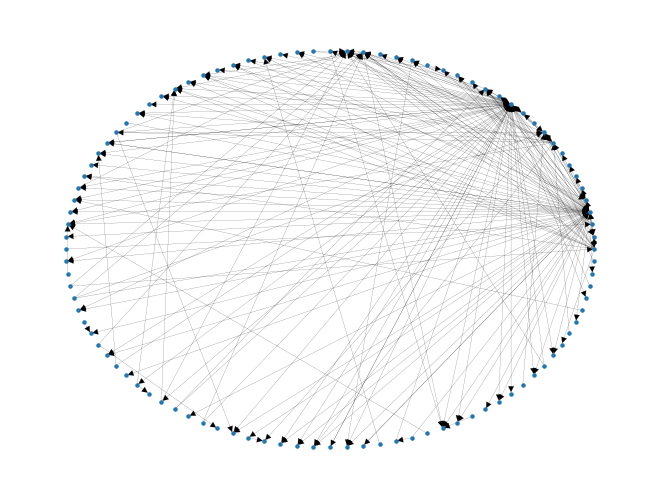

In [15]:
net = X[0]
data = BaseModel.nx2geometric("cpu", net, x_attr=None, label=1)
draw_network(net, with_labels=False)

In [16]:
ldp_features = LocalDegreeProfile()(data)
ltp_features = _extract_single_graph_features(
    data=data,
    degree_sum=False,
    shortest_paths=False,
    edge_betweenness=True,
    jaccard_index=True,
    local_degree_score=True,
)

In [17]:
ldp_features

Data(edge_index=[2, 200], weight=[200], num_nodes=100, y=[1], num_edges=200, x=[100, 10])

In [6]:
_aggregate_features(_extract_single_graph_features(
    data=data,
    degree_sum=False,
    shortest_paths=False,
    edge_betweenness=True,
    jaccard_index=True,
    local_degree_score=True,
), n_bins=10)

array([ 95.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,  87.,
         0.,   7.,   0.,   1.,   0.,   3.,   0.,   0.,   2.,  67.,   1.,
         8.,   0.,   3.,   0.,   9.,   0.,   0.,  12.,  72.,   1.,  12.,
         5.,   4.,   1.,   3.,   0.,   0.,   2.,  81.,   2.,   1.,   1.,
         6.,   1.,   4.,   1.,   2.,   1.,  79.,  15.,   1.,   1.,   2.,
         1.,   0.,   0.,   0.,   1.,  51.,   0.,   1.,   0.,   0.,   0.,
        16.,   0.,   0.,  32.,  33.,   1.,   0.,   0.,   0.,   5.,   0.,
        26.,  24.,  11.,  33.,   3.,   2.,   1.,   2.,   6.,  10.,   5.,
        22.,  16.,  69.,  11.,   1.,   3.,   1.,   8.,   4.,   2.,   0.,
         1., 129.,  43.,  26.,   2.,   1.,   1.,   0.,   0.,   0.,   1.,
        58.,  27.,   9.,   4.,   7.,   2.,   1.,   2.,   1.,   1.,   2.,
        66.,  46.,   5.,   7.,   3.,   3.,   3.,   0.,  68.],
      dtype=float32)

In [ ]:
row, col = data.edge_index
N = data.num_nodes
row, col, N

deg_out = degree(row, N, dtype=torch.float).view(-1, 1)
deg_in = degree(col, N, dtype=torch.float).view(-1, 1)
xs = [deg_out] + aggr(deg_out[col], row, dim_size=N) + [deg_in] + aggr(deg_in[row], col, dim_size=N)

data.x = torch.cat(xs, dim=-1)

In [ ]:
print(f"Degree out: {deg_out.reshape(-1)}\nDegree in:  {deg_in.reshape(-1)}")
print(f"\nRow: {row}\nCol: {col}")
print(f"\nNei_out: {deg_out[col].reshape(-1)}\nNei_in:  {deg_in[row].reshape(-1)}")

In [ ]:
data